<h1 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 36px;
    color: #2C3E50;
    text-align: center;
    border-bottom: 2px solid #BDC3C7;
    padding-bottom: 10px;
    margin-bottom: 20px;
">
    Evaluation of NodeGrade on Public Datasets
</h1>


In [1]:
# libraries
import os
import re
from loguru import logger
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

import seaborn as sns

# add missing attributes (monkey patch for compatibility with tikzplotlib)
Line2D._us_dashSeq = property(lambda self: self._dash_pattern[1])
Line2D._us_dashOffset = property(lambda self: self._dash_pattern[0])
Legend._ncol = property(lambda self: self._ncols)
import tikzplotlib
import numpy as np
import json
import sys

# custom imports
from src import EvaluationDataClass

from helpers import (
    scale_column,
    check_ranges,
    performance_metrics,
    calculate_kappa_scores,
    evaluate_classification,
    optimize_threshold,
    plot_metric_vs_threshold,
    customized_html_export
)

from visualization import (
    actual_vs_fitted_plots,
    actual_vs_fitted_boxplots,
    actual_vs_fitted_heatmaps
)


flags = {}
os.makedirs("./exports", exist_ok=True)


<h2 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 28px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px solid #BDC3C7;
    padding-bottom: 5px;
    margin-top: 30px;
    margin-bottom: 10px;
">
    Configurations
</h2>


In [2]:
# Configure logger
logger.remove()
_=logger.add(sys.stderr, level="INFO")

In [3]:
# Configure alias, detailed name, filepaths and configurations regarding 
# data preparation for each dataset 

datasets_metadata = {
    'mohler_en': {
        'filepath': './data/ng_mohler-20250123192635_en.json',
        'detailed_name': 'Mohler (english prompts)',
        'scaling_model_score': {
            'perform_scaling': True,
            'new_min':0.0,
            'new_max':5.0,
            'old_min':0.0,
            'old_max':100.0
        },
        'rounding_step': 0.5
    },

    'mohler_de': {
        'filepath': './data/ng_mohler-20250123213529_de.json',
        'detailed_name': 'Mohler (german prompts)',
        'scaling_model_score': {
            'perform_scaling': True,
            'new_min':0.0,
            'new_max':5.0,
            'old_min':0.0,
            'old_max':100.0
        },
        'rounding_step': 0.5
    },
    
    'engsaf': {
        'filepath': './data/ng_engsaf-20250123041225.json',
        'detailed_name':  'Engineering Short Answer Feedback',
        'scaling_model_score': {
            'perform_scaling': True,
            'new_min':0.0,
            'new_max':2.0,
            'old_min':0.0,
            'old_max':100.0
        },
        'rounding_step': 1.0        
    },

    'semeval': {
        'filepath': './data/ng_semeval-20250129_en.json',
        'detailed_name':  'SemEval 2013',
        'scaling_model_score': {
            'perform_scaling': True,
            'new_min':0.0,
            'new_max':1.0,
            'old_min':0.0,
            'old_max':100.0
        },
        'rounding_step': 1.0,
        'flatten_json_in_results': ['metadata']
    },

    'os_en': {
        'filepath': './data/ng_os-20250129210935.json',
        'detailed_name': 'OS Dataset (english prompts)',
        'scaling_model_score': {'perform_scaling': False},
        'flatten_json_in_results': ['metadata']
    },

    'os_de': {
        'filepath': './data/ng_os-20250130000947.json',
        'detailed_name':  'OS Dataset (german prompts)',
        'scaling_model_score': {'perform_scaling': False},
        'flatten_json_in_results': ['metadata']
    }
}

<h2 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 28px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px solid #BDC3C7;
    padding-bottom: 5px;
    margin-top: 30px;
    margin-bottom: 10px;
">
    Load Data
</h2>


In [4]:
# Load data
evaluation_data = EvaluationDataClass(
    datasets_metadata=datasets_metadata
)

# Check ranges regarding human_score and model_score
check_ranges(
    evaluation_data,
    ['human_score', 'model_score'],
    output_mode = 'return_df'
)

2025-03-12 07:19:09.314 | INFO     | src.dataset:_load_data:40 - Loading evaluation data from ./data/ng_mohler-20250123192635_en.json
2025-03-12 07:19:09.332 | INFO     | src.dataset:_load_data:40 - Loading evaluation data from ./data/ng_mohler-20250123213529_de.json
2025-03-12 07:19:09.349 | INFO     | src.dataset:_load_data:40 - Loading evaluation data from ./data/ng_engsaf-20250123041225.json
2025-03-12 07:19:09.372 | INFO     | src.dataset:_load_data:40 - Loading evaluation data from ./data/ng_semeval-20250129_en.json
2025-03-12 07:19:09.759 | INFO     | src.dataset:_load_data:40 - Loading evaluation data from ./data/ng_os-20250129210935.json
2025-03-12 07:19:09.776 | INFO     | src.dataset:_load_data:40 - Loading evaluation data from ./data/ng_os-20250130000947.json


,Dataset Alias,Detailed Name,Column,Min,Max
0,mohler_en,Mohler (english prompts),human_score,0.0,5.0
1,mohler_en,Mohler (english prompts),model_score,1.3,100.0
2,mohler_de,Mohler (german prompts),human_score,0.0,5.0
3,mohler_de,Mohler (german prompts),model_score,1.3,100.0
4,engsaf,Engineering Short Answer Feedback,human_score,0.0,2.0
5,engsaf,Engineering Short Answer Feedback,model_score,-5.0,100.0
6,semeval,SemEval 2013,human_score,0.0,5.0
7,semeval,SemEval 2013,model_score,-5.5,100.0
8,os_en,OS Dataset (english prompts),human_score,0.0,40.0
9,os_en,OS Dataset (english prompts),model_score,0.0,100.0


<h2 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 28px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px solid #BDC3C7;
    padding-bottom: 5px;
    margin-top: 30px;
    margin-bottom: 10px;
">
    Data Preparation
</h2>


In [5]:
dimtables = {}

# Data-Prepration
for alias in datasets_metadata.keys():
    # get reference of dataset
    dataset = evaluation_data.get_dataset(alias)

    # set negative values in model_score to zero
    dataset.df.loc[dataset.df['model_score'] < 0, 'model_score'] = 0

    # Rescale model_score, if specified
    perform_scaling = datasets_metadata.get(alias, {}).get('scaling_model_score', {}).get('perform_scaling', False)
    
    if perform_scaling:
        # save original model_score without negative values, but before scaling
        dataset.df['model_score_original'] = dataset.df['model_score']
        dataset.df = scale_column(
            df=dataset.df,
            column_name='model_score',
            new_min=datasets_metadata[alias]['scaling_model_score']['new_min'],
            new_max=datasets_metadata[alias]['scaling_model_score']['new_max'],
            old_min=datasets_metadata[alias]['scaling_model_score']['old_min'],
            old_max=datasets_metadata[alias]['scaling_model_score']['old_max']
        )   
        logger.info(f"\nScaled variables 'model_score' for dataset '{alias}'")
    else:
        logger.info(f"\nSkipping scaling for dataset {alias}.")

    # Special data preparation for OS Datasets
    if alias in ['os_en', 'os_de']:
        # drop duplicates and log
        n_rows = dataset.df.shape[0]
        print(n_rows)
        dataset.df = dataset.df.drop_duplicates(subset=[
           'model_score', 
            'human_score', 
            'student_answer', 
            'instructor_answer',
            'question'
        ], keep = 'first')
        n_dropped_duplicates = n_rows - dataset.df.shape[0]
        if n_dropped_duplicates > 0:
            logger.info(f"Dropped {n_dropped_duplicates} duplicates (Alias: {alias})")
        else:
            logger.info(f"Dropped no duplicates (Alias: {alias})")
        
        # standardize human_score (each question differs in its possible maximum score)
        dataset.df['human_score_zero_hundred_scaled'] = (
            dataset.df['human_score'] / dataset.df['metadata_full_points']
        ) * 100        

        # retain original model_score
        dataset.df['model_score_original'] = dataset.df['model_score'] 

        # Rescale model_score to human_score scale
        dataset.df['model_score'] = (
            dataset.df['model_score'] / 100
        ) * dataset.df['metadata_full_points']

        # round model score to nearest absolute number
        dataset.df['model_score_rounded'] = round(dataset.df['model_score'])

        # build question id based on github folder names
        dataset.df['question_id_2'] = dataset.df['question_id'].str[0].astype(int)

        # get unique questions and build relation table
        question_id_dimension_table = evaluation_data.datasets[alias].df.filter([
            'instructor_answer',
            'metadata_full_points',
            'question_id_2'
        ]).drop_duplicates().reset_index(drop=True).assign(custom_question_id=lambda df: range(1, len(df) + 1))
    
        # build and save relation table
        dimtables[alias] = question_id_dimension_table
        question_id_dimension_table.to_csv(f'./exports/dim_table_custom_question_id_{alias}.csv')
        
        # update dataset
        evaluation_data.datasets[alias].df = evaluation_data.datasets[alias].df.merge(
            question_id_dimension_table.drop(columns=['question_id_2']),
            on=['instructor_answer', 'metadata_full_points'],
            how='left'
        )
        
        # log action
        msg = f"Performed special data preparation for dataset {alias}"
        logger.info(msg)
        # set flag that os dataset was prepared
        flags['prepared_os_data'] = True

 
    # Apply rounding based on dataset-specific configurations to achieve a
    # model_score that aligns with the discrete steps of the corresponding
    # human_score scale, ensuring consistency between predicted and actual scoring systems.
    rounding_step = datasets_metadata.get(alias, {}).get('rounding_step', None)
    if rounding_step is not None:
        dataset.df['model_score_rounded'] = dataset.df['model_score'].apply(
            lambda x: round(x / rounding_step) * rounding_step
        )
        logger.info(f"\nRounded 'model_score' to nearest rounding step ({rounding_step}) for dataset '{alias}' and stored the result in new column named 'model_score_rounded'")
    else:
        logger.info(f"\nNo rounding_step defined for dataset '{alias}'. Skipping rounding.")

if not flags['prepared_os_data']:
    logger.warn("OS-Dataset-Handling Flag not set. Changed alias? -> Problem! Removed dataset? -> Calm down!")

# QS: Check ranges
pd.concat([
    check_ranges(
        evaluation_data,
        ['human_score', 'model_score', 'model_score_rounded', 'model_score_original'],
        output_mode = 'return_df',
        exclude_aliases = ['os_en', 'os_de']
    ),
    
    check_ranges(
        evaluation_data,
        ['human_score', 'model_score', 'model_score_rounded', 'human_score_zero_hundred_scaled'],
        output_mode = 'return_df',
        include_aliases = ['os_en', 'os_de']
    )
])

2025-03-12 07:19:09.822 | INFO     | __main__:<module>:25 - 
Scaled variables 'model_score' for dataset 'mohler_en'
2025-03-12 07:19:09.827 | INFO     | __main__:<module>:99 - 
Rounded 'model_score' to nearest rounding step (0.5) for dataset 'mohler_en' and stored the result in new column named 'model_score_rounded'
2025-03-12 07:19:09.830 | INFO     | __main__:<module>:25 - 
Scaled variables 'model_score' for dataset 'mohler_de'
2025-03-12 07:19:09.833 | INFO     | __main__:<module>:99 - 
Rounded 'model_score' to nearest rounding step (0.5) for dataset 'mohler_de' and stored the result in new column named 'model_score_rounded'
2025-03-12 07:19:09.836 | INFO     | __main__:<module>:25 - 
Scaled variables 'model_score' for dataset 'engsaf'
2025-03-12 07:19:09.839 | INFO     | __main__:<module>:99 - 
Rounded 'model_score' to nearest rounding step (1.0) for dataset 'engsaf' and stored the result in new column named 'model_score_rounded'
2025-03-12 07:19:09.843 | INFO     | __main__:<modul

720
720


,Dataset Alias,Detailed Name,Column,Min,Max
0,mohler_en,Mohler (english prompts),human_score,0.000,5.00
1,mohler_en,Mohler (english prompts),model_score,0.065,5.00
2,mohler_en,Mohler (english prompts),model_score_rounded,0.000,5.00
3,mohler_en,Mohler (english prompts),model_score_original,1.300,100.00
4,mohler_de,Mohler (german prompts),human_score,0.000,5.00
5,mohler_de,Mohler (german prompts),model_score,0.065,5.00
6,mohler_de,Mohler (german prompts),model_score_rounded,0.000,5.00
7,mohler_de,Mohler (german prompts),model_score_original,1.300,100.00
8,engsaf,Engineering Short Answer Feedback,human_score,0.000,2.00
9,engsaf,Engineering Short Answer Feedback,model_score,0.000,2.00


<h2 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 28px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px solid #BDC3C7;
    padding-bottom: 5px;
    margin-top: 30px;
    margin-bottom: 10px;
">
    Visual Analysis
</h2>


2025-03-12 07:19:10.371 | INFO     | visualization.actual_vs_fitted_boxplots:actual_vs_fitted_boxplots:231 - Saved individual boxplot to './exports/fitvsact_boxplot_mohler_en.png' and './exports/fitvsact_boxplot_mohler_en.tex'
2025-03-12 07:19:10.758 | INFO     | visualization.actual_vs_fitted_boxplots:actual_vs_fitted_boxplots:231 - Saved individual boxplot to './exports/fitvsact_boxplot_mohler_de.png' and './exports/fitvsact_boxplot_mohler_de.tex'
2025-03-12 07:19:11.036 | INFO     | visualization.actual_vs_fitted_boxplots:actual_vs_fitted_boxplots:231 - Saved individual boxplot to './exports/fitvsact_boxplot_engsaf.png' and './exports/fitvsact_boxplot_engsaf.tex'
2025-03-12 07:19:11.329 | INFO     | visualization.actual_vs_fitted_boxplots:actual_vs_fitted_boxplots:231 - Saved individual boxplot to './exports/fitvsact_boxplot_semeval.png' and './exports/fitvsact_boxplot_semeval.tex'


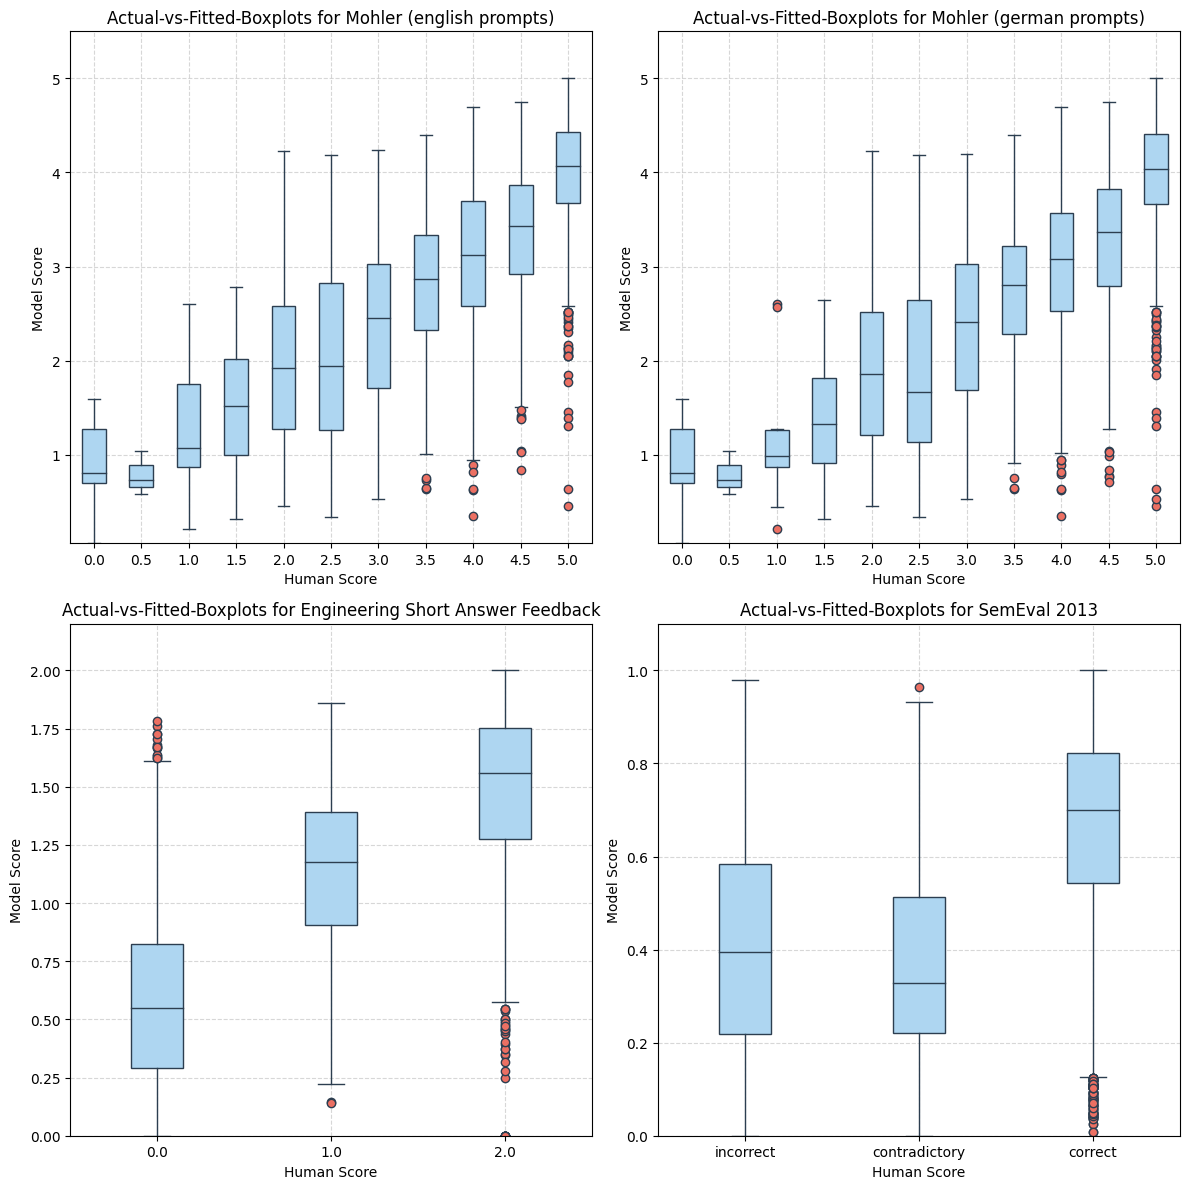

In [6]:
actual_vs_fitted_boxplots(
    evaluation_data=evaluation_data,
    format_x_labels=False,
    layout="horizontal",
    y_col="model_score",
    x_col="human_score",
    grouping_overrides={"semeval": "metadata_original_label"},
    order_overrides={"semeval": ["incorrect", "contradictory", "correct"]},
    output_filepath_prefix = './exports/fitvsact_boxplot_',
    exclude_aliases=["os_en", "os_de"]
)

2025-03-12 07:19:12.221 | INFO     | visualization.actual_vs_fitted_boxplots:actual_vs_fitted_boxplots:231 - Saved individual boxplot to './exports/fitvsact_boxplot_binary_semeval.png' and './exports/fitvsact_boxplot_binary_semeval.tex'


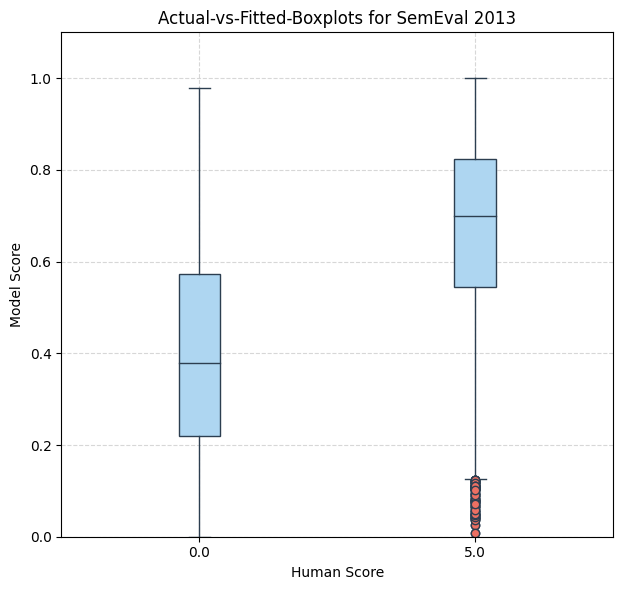

In [7]:
# Für Semeval steht neben dem Merkmal metadata_original_label auch ein binäres Grading zur Verfügung:
actual_vs_fitted_boxplots(
    evaluation_data=evaluation_data,
    format_x_labels=False,
    layout="horizontal",
    y_col="model_score",
    x_col="human_score",
    include_aliases = ['semeval'],
    output_filepath_prefix = './exports/fitvsact_boxplot_binary_',
)

2025-03-12 07:19:13.281 | INFO     | visualization.actual_vs_fitted_heatmaps:actual_vs_fitted_heatmaps:214 - Saved individual heatmap to './exports/heatmap_mohler_en.png' and './exports/heatmap_mohler_en.tex'
2025-03-12 07:19:14.073 | INFO     | visualization.actual_vs_fitted_heatmaps:actual_vs_fitted_heatmaps:214 - Saved individual heatmap to './exports/heatmap_mohler_de.png' and './exports/heatmap_mohler_de.tex'
2025-03-12 07:19:14.629 | INFO     | visualization.actual_vs_fitted_heatmaps:actual_vs_fitted_heatmaps:214 - Saved individual heatmap to './exports/heatmap_engsaf.png' and './exports/heatmap_engsaf.tex'
2025-03-12 07:19:15.185 | INFO     | visualization.actual_vs_fitted_heatmaps:actual_vs_fitted_heatmaps:214 - Saved individual heatmap to './exports/heatmap_semeval.png' and './exports/heatmap_semeval.tex'


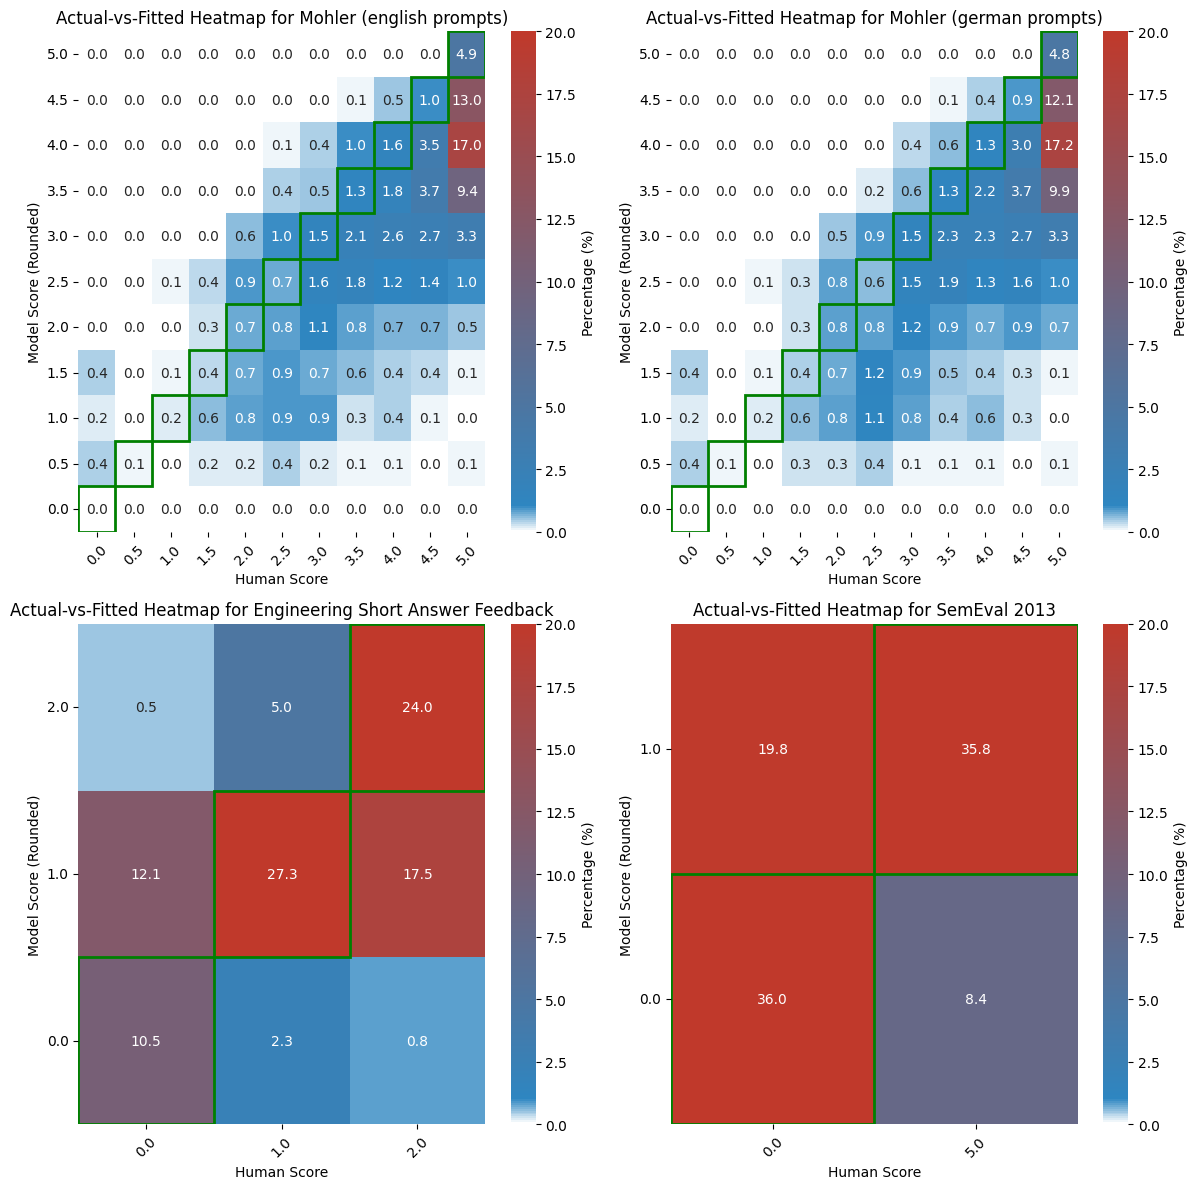

In [8]:
actual_vs_fitted_heatmaps(
    evaluation_data,
    y_col="model_score_rounded",
    x_col="human_score",
    absolute = False,
    vmin=0,
    vmax=20,
    diagonal_color='green',
    output_filepath_prefix="./exports/heatmap_",
    exclude_aliases=["os_en", "os_de"]
)

2025-03-12 07:19:16.547 | INFO     | visualization.actual_vs_fitted_plots:actual_vs_fitted_plots:155 - Saved individual scatter plot to './exports/scatter_contin_os_en.png' and './exports/scatter_contin_os_en.tex'
2025-03-12 07:19:17.125 | INFO     | visualization.actual_vs_fitted_plots:actual_vs_fitted_plots:155 - Saved individual scatter plot to './exports/scatter_contin_os_de.png' and './exports/scatter_contin_os_de.tex'


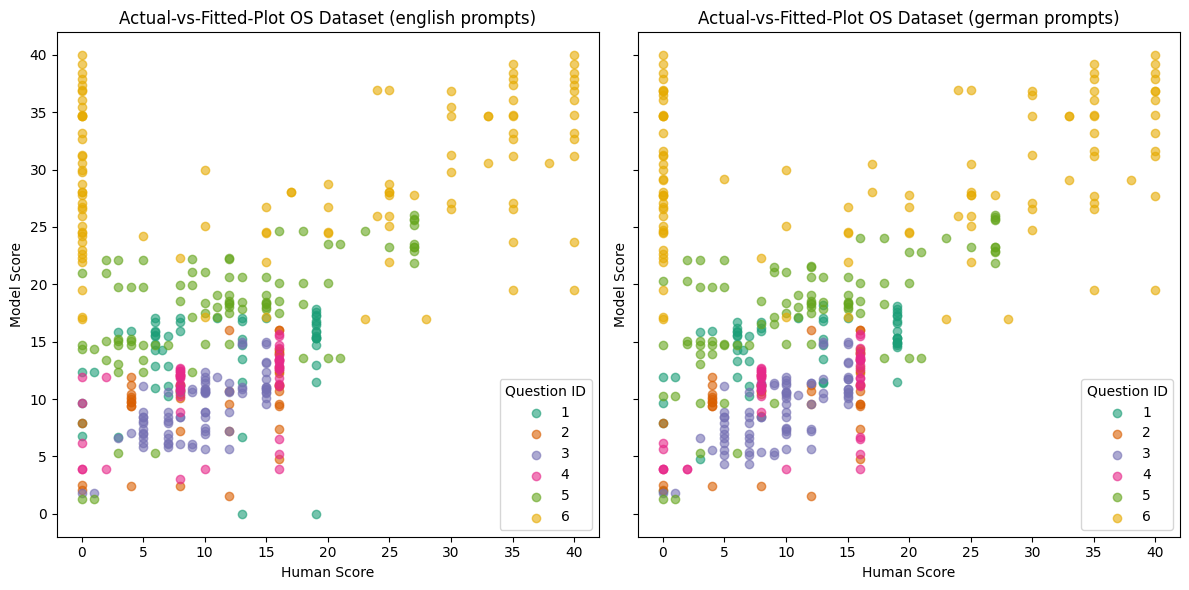

In [9]:
# ensure corrrect sorting
for al in ['os_en', 'os_de']:
    evaluation_data.datasets[al].df = evaluation_data.datasets[al].df.sort_values(by='question_id_2')

actual_vs_fitted_plots(
    evaluation_data = evaluation_data, 
    x_col = 'human_score',
    y_col = 'model_score',
    x_label = 'Human Score',
    y_label = 'Model Score',
    layout = "horizontal", 
    group_by='question_id_2',
    legend_title="Question ID",
    include_aliases = ['os_en', 'os_de'],
    output_filepath_prefix = './exports/scatter_contin_',
    cmap_str = "Dark2" 
)

__Whats's up with question 6?__

In [10]:
for i in range(5):
    example_row = evaluation_data.datasets['os_en'].df.query(
        'question_id_2 == 6'
    ).filter(['question', 'instructor_answer']).drop_duplicates().values[i]

    print(f"------------\nExample  {i}\n-----------")
    print("Question")
    print(f"\n{example_row[0]}\n")
    print("Instructor Answer")
    print(f"\n{example_row[1]}\n")

------------
Example  0
-----------
Question

Use the simulator paging-multilevel-translate.py to perform translations. Run: $ ./paging-multilevel-translate.py -s 3103 You are given the value of the PDBR, a complete dump of each page of memory, and a list of virtual addresses to translate. Solutions to the first two addresses are given below for reference: Virtual Address 4a14: Translates to what Physical Address (and fetches what value)? Or Fault? Virtual Address 4a14: --> pde index:0x12 [decimal 18] pde contents:0x9a (valid 1, pfn 0x1a [decimal 26]) --> pte index:0x10 [decimal 16] pte contents:0xd8 (valid 1, pfn 0x58 [decimal 88]) --> Translates to Physical Address 0xb14 --> Value: 17 Virtual Address 685e: Translates to what Physical Address (and fetches what value)? Or Fault? Virtual Address 685e: --> pde index:0x1a [decimal 26] pde contents:0xbf (valid 1, pfn 0x3f [decimal 63]) --> pte index:0x2 [decimal 2] pte contents:0x7f (valid 0, pfn 0x7f [decimal 127]) --> Fault (page table e

2025-03-12 07:19:18.201 | INFO     | visualization.actual_vs_fitted_plots:actual_vs_fitted_plots:155 - Saved individual scatter plot to './exports/scatter_discr_os_en.png' and './exports/scatter_discr_os_en.tex'
2025-03-12 07:19:18.704 | INFO     | visualization.actual_vs_fitted_plots:actual_vs_fitted_plots:155 - Saved individual scatter plot to './exports/scatter_discr_os_de.png' and './exports/scatter_discr_os_de.tex'


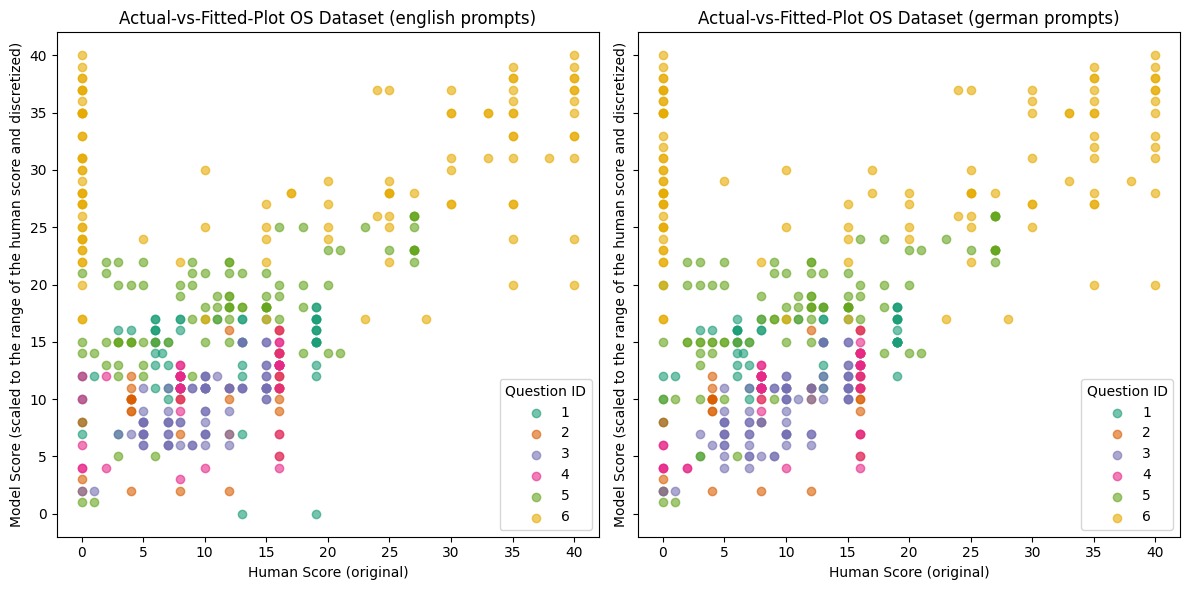

In [11]:
actual_vs_fitted_plots(
    evaluation_data = evaluation_data, 
    x_col = 'human_score',
    y_col = 'model_score_rounded',
    x_label = 'Human Score (original)',
    y_label = 'Model Score (scaled to the range of the human score and discretized)',
    layout = "horizontal", 
    group_by='question_id_2',
    legend_title="Question ID",
    include_aliases = ['os_en', 'os_de'],
    output_filepath_prefix = './exports/scatter_discr_',
    cmap_str = "Dark2" 
)

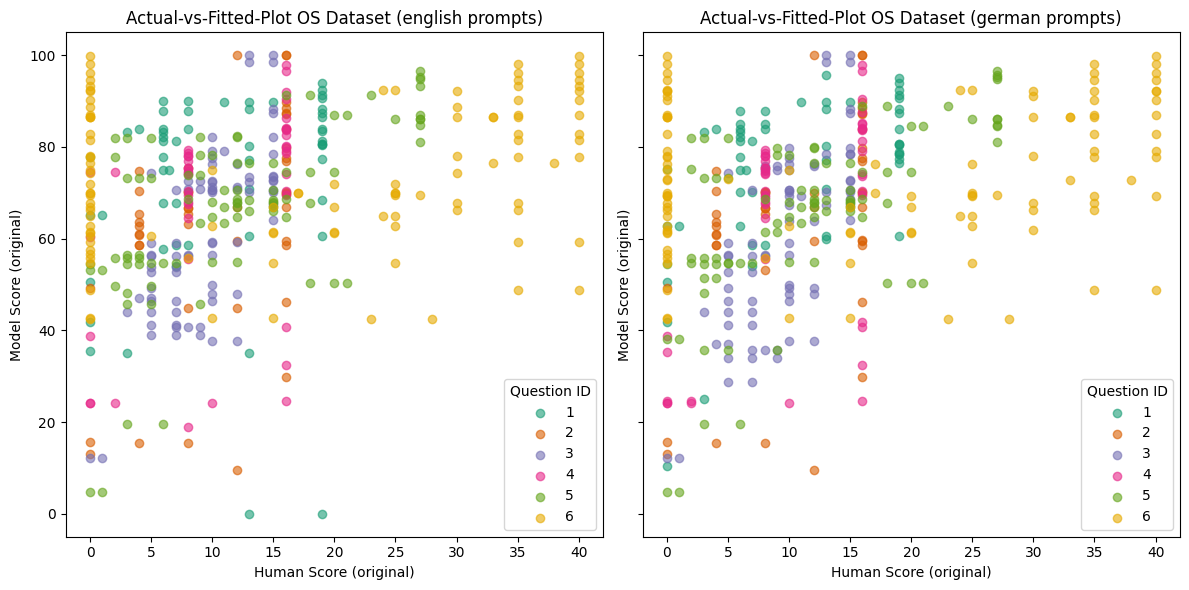

In [12]:
actual_vs_fitted_plots(
    evaluation_data = evaluation_data, 
    x_col = 'human_score',
    y_col = 'model_score_original',
    x_label = 'Human Score (original)',
    y_label = 'Model Score (original)',
    layout = "horizontal", 
    group_by='question_id_2',
    legend_title="Question ID",
    include_aliases = ['os_en', 'os_de'],
    cmap_str = "Dark2"
)

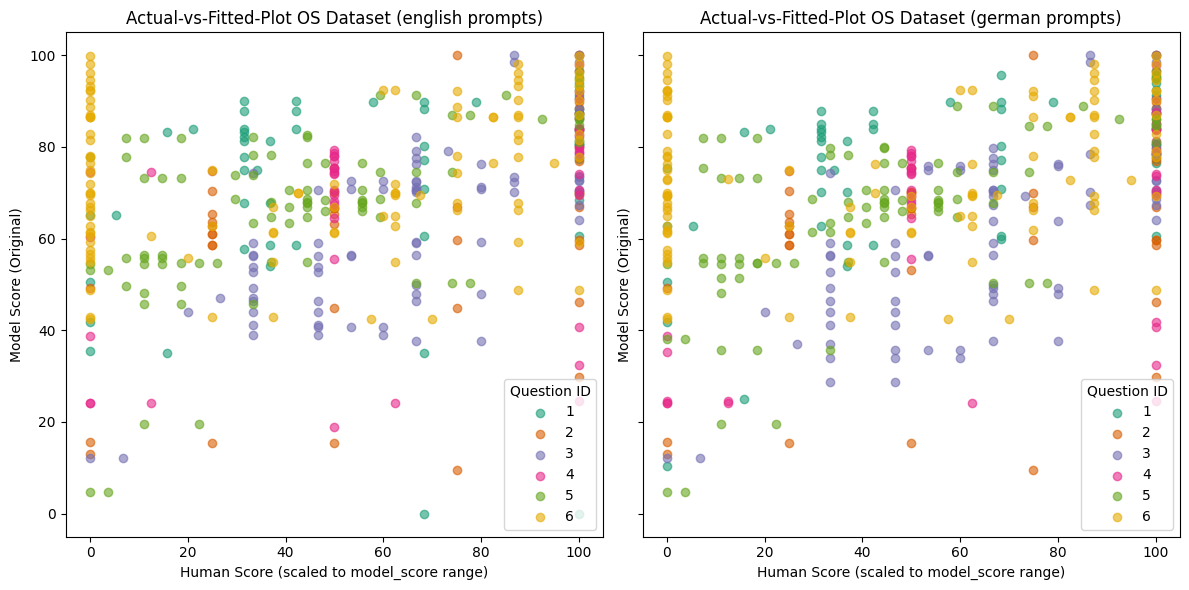

In [13]:
actual_vs_fitted_plots(
    evaluation_data = evaluation_data, 
    x_col = 'human_score_zero_hundred_scaled',
    y_col = 'model_score_original',
    x_label = 'Human Score (scaled to model_score range)',
    y_label = 'Model Score (Original)',
    layout = "horizontal", 
    group_by='question_id_2',
    legend_title="Question ID",
    include_aliases = ['os_en', 'os_de'],
    cmap_str = "Dark2"
)

<h2 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 28px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px solid #BDC3C7;
    padding-bottom: 5px;
    margin-top: 30px;
    margin-bottom: 10px;
">
    Formal Analysis
</h2>


* $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

* $\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$


* __$R^2$__
> Total Sum of Squares
> 
> $ \text{SST} = \sum_{i=1}^{n} (Y_i - \overline{Y})^2$
> 
> Residual Sum of Squares
> 
> $ \text{SSR} = \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 $
> 
> Anteil erklärter Varianz:
> 
> $ R^2 = 1 - \frac{\text{SSR}}{\text{SST}} $

* $\text{Precision} = \frac{TP}{TP + FP}$

* $\text{Recall} = \frac{TP}{TP + FN}$

* $\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

* $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$

* $\text{Specificity} = \frac{TN}{TN + FP}$

* $\text{FPR} = \frac{FP}{FP + TN}$

* $\text{FNR} = \frac{FN}{FN + TP}$

* $\text{MCC} = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}$


<h3 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 22px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 20px;
    margin-bottom: 10px;
">
    Regresion metrics
</h3>


In [14]:
y_hat = 'model_score'
y = 'human_score'
get_this_metrics = ["RMSE", "MAE", "Pearson"]

# rowbind results
metrics = pd.concat([
    # calculate metrics for all datasets
    performance_metrics(
        evaluation_data,
        y_col = y,
        y_hat_col = y_hat,
        metrics = get_this_metrics
    ),
    # special call regarding Dataset SemEval I (Filter for corpus 'sciEntsBank')
    performance_metrics(
        evaluation_data,
        y_col = y,
        y_hat_col = y_hat,
        include_aliases = 'semeval',
        metrics = get_this_metrics,
        filters = {"semeval": "metadata_corpus == 'sciEntsBank'"}
    ),
    # special call regarding Dataset SemEval II (Filter for corpus 'beetle')
     performance_metrics(
        evaluation_data,
        y_col = y,
        y_hat_col = y_hat,
        include_aliases = 'semeval',
        metrics = get_this_metrics,
        filters = {"semeval": "metadata_corpus == 'beetle'"}
    )
])

del y, y_hat, get_this_metrics
metrics

2025-03-12 07:19:20.641 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset semeval
2025-03-12 07:19:20.691 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset semeval


,alias,Detailed Name,RMSE,MAE,Pearson,filter
0,mohler_en,Mohler (english prompts),1.365481,0.968605,0.732310,NaN
1,mohler_de,Mohler (german prompts),1.464258,1.003707,0.733963,NaN
2,engsaf,Engineering Short Answer Feedback,0.337244,0.466819,0.675959,NaN
3,semeval,SemEval 2013,8.416871,2.135822,0.529131,NaN
4,os_en,OS Dataset (english prompts),128.697302,7.556726,0.430688,NaN
5,os_de,OS Dataset (german prompts),126.327437,7.398171,0.443000,NaN
0,semeval,SemEval 2013,7.837625,2.036140,0.591964,metadata_corpus == 'sciEntsBank'
0,semeval,SemEval 2013,8.981610,2.233007,0.478838,metadata_corpus == 'beetle'


In [15]:
performance_metrics(
    evaluation_data,
    y_col = "human_score_zero_hundred_scaled",
    y_hat_col = "model_score_original",
    include_aliases = ['os_en', 'os_de'],
    metrics = ["RMSE", "MAE", "R2", "Pearson"],
)

,alias,Detailed Name,RMSE,MAE,R2,Pearson
0,os_en,OS Dataset (english prompts),1317.041082,28.255329,-0.104950,0.340443
1,os_de,OS Dataset (german prompts),1246.615634,27.405708,-0.045865,0.387386


In [16]:
special_results_os_dataset = {}

for alias in ['os_en', 'os_de']:

    # create an empty dataframe
    results = metrics.query("Pearson == 'i need an empty dataframe'")
    
    question_ids = np.sort(evaluation_data.datasets[alias].df['question_id_2'].unique())
    
    
    for cur_id in question_ids:    
        new_entry = performance_metrics(
            evaluation_data,
            y_col = 'human_score',
            y_hat_col = 'model_score',
            metrics =  ["RMSE", "MAE", "Pearson"],
            include_aliases = alias,
            filters = {alias: f"question_id_2 == {cur_id}"}
        )
        
        results = pd.concat([results, new_entry])

        special_results_os_dataset[alias] = results

2025-03-12 07:19:20.757 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_en
2025-03-12 07:19:20.765 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_en
2025-03-12 07:19:20.774 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_en
2025-03-12 07:19:20.783 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_en
2025-03-12 07:19:20.790 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_en
2025-03-12 07:19:20.797 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_en
2025-03-12 07:19:20.807 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_de
2025-03-12 07:19:20.813 | INFO     | helpers.performance_metrics:performance_metrics:73 - Applied filter on dataset os_de
2025-03-12 07:19:20.820 

In [17]:
special_results_os_dataset['os_en'].sort_values(by="Pearson", ascending = False)

,alias,Detailed Name,RMSE,MAE,Pearson,filter
0,os_en,OS Dataset (english prompts),7.074150,2.231731,0.703370,question_id_2 == 3
0,os_en,OS Dataset (english prompts),81.631668,7.518227,0.601089,question_id_2 == 5
0,os_en,OS Dataset (english prompts),24.946170,4.294044,0.462509,question_id_2 == 2
0,os_en,OS Dataset (english prompts),26.995456,4.359273,0.424048,question_id_2 == 4
0,os_en,OS Dataset (english prompts),379.131649,14.826542,0.227063,question_id_2 == 6
0,os_en,OS Dataset (english prompts),54.171168,6.230352,0.225075,question_id_2 == 1


In [18]:
special_results_os_dataset['os_de'].sort_values(by="Pearson", ascending = False)

,alias,Detailed Name,RMSE,MAE,Pearson,filter
0,os_de,OS Dataset (german prompts),7.505761,2.263077,0.696432,question_id_2 == 3
0,os_de,OS Dataset (german prompts),75.554382,7.180727,0.624948,question_id_2 == 5
0,os_de,OS Dataset (german prompts),22.081420,4.024727,0.550735,question_id_2 == 4
0,os_de,OS Dataset (german prompts),42.636166,5.549019,0.514925,question_id_2 == 1
0,os_de,OS Dataset (german prompts),24.965513,4.257778,0.459299,question_id_2 == 2
0,os_de,OS Dataset (german prompts),382.435469,14.961495,0.218421,question_id_2 == 6


<h3 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 22px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 20px;
    margin-bottom: 10px;
">
    Further metrics (dataset specific calculations)
</h3>

In [19]:
formal_results = {}

<h4 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 18px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 18px;
    margin-bottom: 8px;
">
    EngSAF
</h4>


EngSAF verfügt über ein Label mit drei Kategorien: `correct`, `contradicting` `incorrect`

Das bedeutet:
* Regressionmaße a la $R^2$, RMSE, MAE oder Pearsons $r$ in meinen Augen Unsinn.
* Weighted Cohens Kappa zwischen ordinal transformierter Vorhersage und True-Label sinnig.
* ROC-AUC-Werte können mit etwas Kniff für jede Klasse separat berechnet werden.

In [20]:
# specify alias
alias = 'engsaf'

# initialize results dictionairy
formal_results[alias] = {}

# copy dataset
df = evaluation_data.datasets[alias].df.copy()

# specify and prepare model and human_scores
model_scores = df['model_score_rounded'].astype(int) # classes: 0, 1, 2 ()
human_scores = df['human_score'].astype(int) # classes: 0, 1, 2

__Cohens Kappa__

In [21]:
# calculate Kappa-Scores
formal_results[alias]['kappa'] = calculate_kappa_scores(
    human_scores,
    model_scores
)

Unweighted Kappa:		 0.41
Quadratic Weighted Kappa:	 0.59
Linear Weighted Kappa:		 0.49


__ROC-Curve for each class__

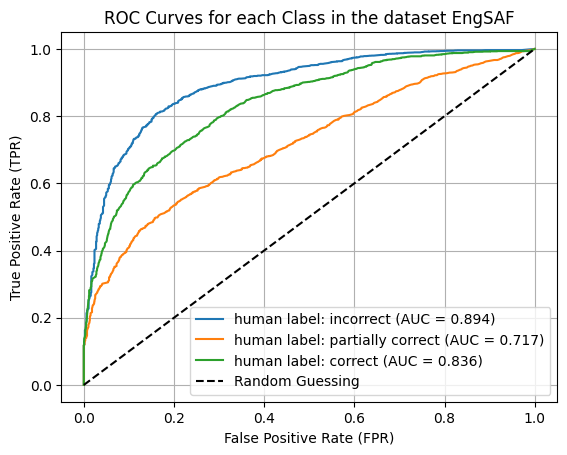

In [22]:
distinct_human_scores = df['human_score'].unique()      
formal_results[alias]['MultiClass_ROC_AUC'] = {}
formal_results[alias]['MultiClass_ROC_AUC']['values'] = {}

for value in distinct_human_scores:
    # create dummies and labels for plots
    value_label = None
    if int(value) == 0:
        dummy = (df['human_score'] != value).astype(int)
        value_label = 'incorrect'
    if int(value) == 1:
        dummy = (df['human_score'] != value).astype(int)
        value_label = 'partially correct'
    elif int(value) == 2:
        dummy = (df['human_score'] == value).astype(int)
        value_label = 'correct'

    # calculate roc auc
    if int(value) in [0, 2]: 
        model_score_original = df['model_score_original']            
        roc_auc = roc_auc_score(dummy, model_score_original)
    elif int(value) == 1: 
        model_score_original = abs(df['model_score_original'] - 50)
        roc_auc = roc_auc_score(dummy, model_score_original)
        
    formal_results[alias]['MultiClass_ROC_AUC']['values'][f'class_{int(value)}'] = float(roc_auc)

    # Calculate the ROC-Curve
    fpr, tpr, thresholds = roc_curve(dummy, model_score_original)

    # plot der ROC-Kurve
    plt.plot(fpr, tpr, label=f'human label: {value_label} (AUC = {roc_auc:.3f})')

# Plot
filename = 'engsaf_roc_curves'
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing') 
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for each Class in the dataset EngSAF')
plt.legend(loc='lower right')
plt.grid()
plt.savefig(f"./exports/{filename}.png")
tikzplotlib.save(f"./exports/{filename}.tex")
plt.show()

del roc_auc

__Calculation of weighted ROC-AUC over all clases__

The weighted ROC-AUC is computed as a weighted sum of the per-class ROC-AUC values, where the weights correspond to the relative frequencies of each class in the dataset.

$\text{Weighted ROC-AUC} = \sum_{i=0}^{N} p_i \cdot \text{ROC-AUC}_i$

where:
- $N$ is the number of classes,
- $p_i$ is the proportion of samples in class \( i \),
- $\text{ROC-AUC}_i$ is the ROC-AUC value for class \( i \).


In [23]:
freqs = df['human_score'].value_counts(normalize=True)
freqs

human_score
2.0    0.422720
1.0    0.346259
0.0    0.231021
Name: proportion, dtype: float64

In [24]:
formal_results[alias]['MultiClass_ROC_AUC']['values']

{'class_0': 0.8936398979824846,
 'class_1': 0.7168385935922877,
 'class_2': 0.8361628457019646}

In [25]:
formal_results[alias]['MultiClass_ROC_AUC']['weighted_roc_auc'] = (
    freqs[0.0] * formal_results[alias]['MultiClass_ROC_AUC']['values']['class_0'] +
    freqs[1.0] * formal_results[alias]['MultiClass_ROC_AUC']['values']['class_1'] +
    freqs[2.0] * formal_results[alias]['MultiClass_ROC_AUC']['values']['class_2']
)

print(f"Weighted ROC-AUC: {formal_results[alias]['MultiClass_ROC_AUC']['weighted_roc_auc']:.4f}")

Weighted ROC-AUC: 0.8081


<h4 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 18px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 18px;
    margin-bottom: 8px;
">
    Mohler
</h4>

Mohler verfügt über ein quasiintervallskaliertes True-Label. Das bedeutet:

* Regressionsmaße a la $R^2$, RMSE, MAE oder Pearsons $r$ sinnvoll mit gewissen Einschränkungen, da nur quasi-intervallskalierte True-Labels.
* Weighted Cohens Kappa zwischen ordinal transformierter Vorhersage und True-Label sinnig.
* ROC-AUC-Werte in meinen Augen nicht sinnvoll berechenbar.

__Regressionsmaße__

In [26]:
# calculations from chapter above
metrics.iloc[:2:]

,alias,Detailed Name,RMSE,MAE,Pearson,filter
0,mohler_en,Mohler (english prompts),1.365481,0.968605,0.732310,NaN
1,mohler_de,Mohler (german prompts),1.464258,1.003707,0.733963,NaN


__Cohens Weighted Kappa__

In [27]:
qs = []

# specify alias
for alias in ['mohler_en', 'mohler_de']:
    print(f"\nAlias: {alias}")
    # initialize results dictionairy
    formal_results[alias] = {}
    
    # copy dataset
    df = evaluation_data.datasets[alias].df.copy()
    
    # specify and prepare model and human_scores     
    # multiplication with 2 because Cohen Kappa needs integer values
    # and is not suitable with decimals
    model_scores = (df['model_score_rounded'] * 2).astype(int)
    human_scores = (df['human_score'] * 2).astype(int)
    
    # qs to check that bevor using int() model_score consists out of natural numbers
    qs.append({
        'model_score_rounded': np.sort((df['model_score_rounded'] * 2).unique()),
        'human_score': np.sort((df['human_score'] * 2).unique())
    })

    # Calculate Kappa Scores
    formal_results[alias]['kappa'] = calculate_kappa_scores(
        human_scores, model_scores
    )

print('\n')
for el in qs: print(el)



Alias: mohler_en
Unweighted Kappa:		 0.03
Quadratic Weighted Kappa:	 0.55
Linear Weighted Kappa:		 0.32

Alias: mohler_de
Unweighted Kappa:		 0.03
Quadratic Weighted Kappa:	 0.54
Linear Weighted Kappa:		 0.31


{'model_score_rounded': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'human_score': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])}
{'model_score_rounded': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 'human_score': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])}


__Checking high discrepance cases__

In [28]:
alias = 'mohler_en'

# select relevant columns
df = evaluation_data.datasets[alias].df.filter([
    'model_score_original',
    'model_score_rounded',
    'model_score',
    'human_score',
    'question',
    'instructor_answer',
    'student_answer'
])

# calculate prediction error (absolute and original)
df['prediction_error'] = (df['model_score'] - df['human_score'])
df['absolute_prediction_error'] = abs(df['prediction_error'])

# mean prediction error per question
df_error_per_ques = df.groupby('question')['prediction_error'].mean().reset_index().sort_values(
    by = 'prediction_error',
    ascending=True)

# Liste der gewünschten Perzentile
percentiles = [75, 80, 85, 90]

# Für jedes Perzentil eine neue Spalte hinzufügen
for p in percentiles:
    col_name = f'percentile_{p}'
    df[col_name] = df.groupby('human_score')['absolute_prediction_error'].transform(
        lambda x: x.quantile(p / 100)
    )


# calculate percentile for each group of 'human_score' and save it as a new column
df_discrepancy = df

df_discrepancy['percentile_rank_grouped'] = df_discrepancy.groupby('human_score')['absolute_prediction_error'].transform(
    lambda x: x.rank(pct=True)
)

df_discrepancy.query("percentile_rank_grouped > 0.75")
# alternatively:
# df_discrepancy.query("absolute_prediction_error > percentile_75") 


,model_score_original,model_score_rounded,model_score,human_score,question,instructor_answer,student_answer,prediction_error,absolute_prediction_error,percentile_75,percentile_80,percentile_85,percentile_90,percentile_rank_grouped
3,56.7,3.0,2.835,5.0,1.1 What is the role of a prototype program in...,1.1 To simulate the behaviour of portions of t...,1.1 Defined in the Specification phase a proto...,-2.165,2.165,1.32000,1.405,1.5300,1.7500,0.961641
14,64.2,3.0,3.210,2.0,1.1 What is the role of a prototype program in...,1.1 To simulate the behaviour of portions of t...,1.1 A prototype program provides a basic groun...,1.210,1.210,0.88000,0.975,1.0975,1.2100,0.901099
17,61.7,3.0,3.085,2.0,1.1 What is the role of a prototype program in...,1.1 To simulate the behaviour of portions of t...,1.1 it provides a limited proof of concept to ...,1.085,1.085,0.88000,0.975,1.0975,1.2100,0.846154
18,64.4,3.0,3.220,2.0,1.1 What is the role of a prototype program in...,1.1 To simulate the behaviour of portions of t...,1.1 It tests the main function of the program ...,1.220,1.220,0.88000,0.975,1.0975,1.2100,0.912088
22,48.7,2.5,2.435,1.5,1.1 What is the role of a prototype program in...,1.1 To simulate the behaviour of portions of t...,1.1 A prototype program is used in problem sol...,0.935,0.935,0.90000,0.927,0.9840,1.0980,0.813953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264,47.4,2.5,2.370,5.0,12.10 How many steps does it take to search a ...,12.10 The height of the tree.,12.10 log -LRB- n -RRB- where n equals the tot...,-2.630,2.630,1.32000,1.405,1.5300,1.7500,0.983497
2266,69.8,3.5,3.490,5.0,12.10 How many steps does it take to search a ...,12.10 The height of the tree.,12.10 to find a node in a binary search tree t...,-1.510,1.510,1.32000,1.405,1.5300,1.7500,0.846120
2267,14.1,0.5,0.705,2.5,12.10 How many steps does it take to search a ...,12.10 The height of the tree.,"12.10 three steps visit the root node, then go...",-1.795,1.795,1.30375,1.411,1.5490,1.6585,0.941667
2268,50.3,2.5,2.515,5.0,12.10 How many steps does it take to search a ...,12.10 The height of the tree.,12.10 log n,-2.485,2.485,1.32000,1.405,1.5300,1.7500,0.977252


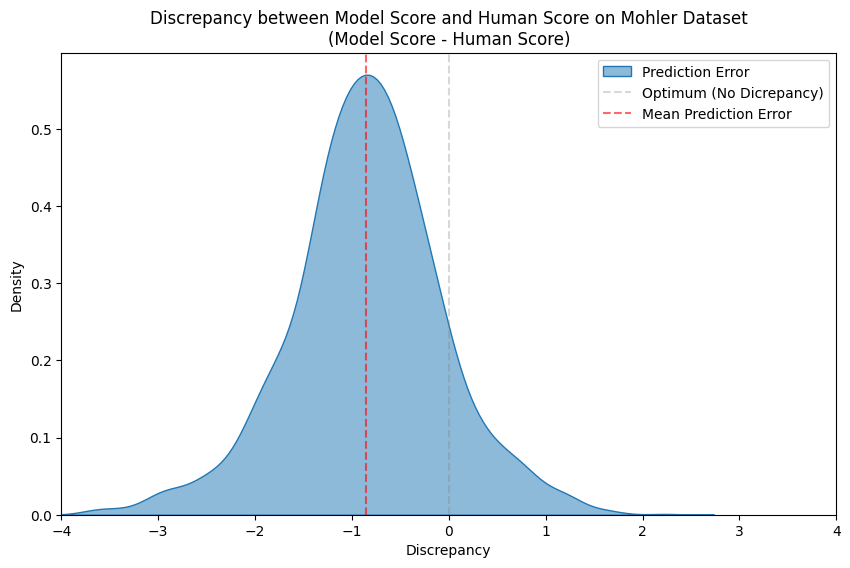

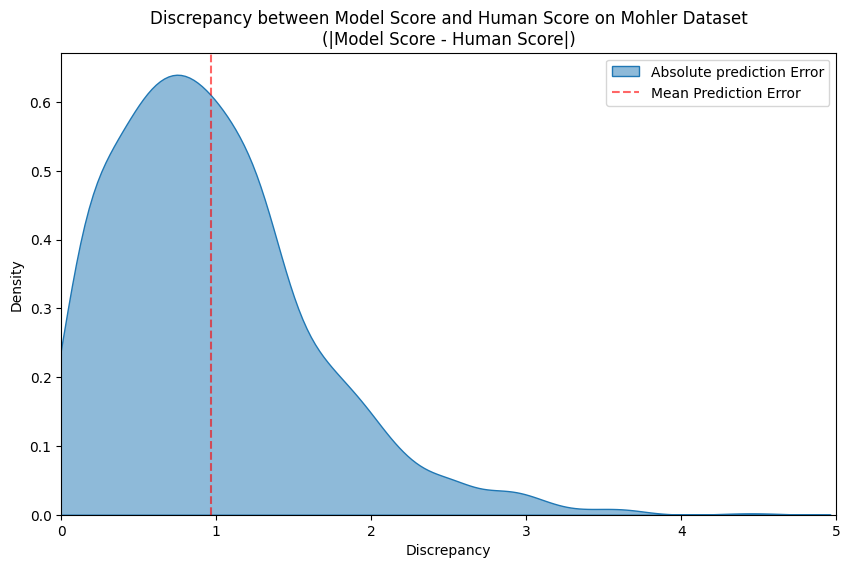

In [29]:
for var in ['prediction_error', 'absolute_prediction_error']:
    mean_error = df_discrepancy[var].mean()
    plt.figure(figsize=(10, 6))
    if var == 'prediction_error':
        label = 'Prediction Error'
        calculation = 'Model Score - Human Score'
        xlims = [-4, 4]
    elif var == 'absolute_prediction_error':
        label = 'Absolute prediction Error'
        calculation = '|Model Score - Human Score|'
        xlims = [0, 5]
    else: 
        continue
    
    sns.kdeplot(df_discrepancy[var], label=label, fill=True, alpha=0.5)
    
    if var == 'prediction_error':
        plt.axvline(x=0, color='gray', linestyle='dashed', alpha=0.3, label='Optimum (No Dicrepancy)') 
        
    plt.axvline(x=mean_error, color='red', linestyle='dashed', alpha=0.6, label='Mean Prediction Error')
    plt.xlabel('Discrepancy')
    plt.ylabel('Density')
    plt.title(f'Discrepancy between Model Score and Human Score on Mohler Dataset\n({calculation})')
    plt.legend()
    plt.xlim(xlims)
    plt.show()

In [30]:
# QS 
percentile_cols = [col for col in df_discrepancy.columns if 'percentile_' in col]
percentile_cols = [col for col in percentile_cols if not col == "percentile_rank_grouped"]
df_bar_plot = df_discrepancy.filter(
    ['human_score'] + percentile_cols
).drop_duplicates().sort_values(by=['human_score']).reset_index(drop=True)

df_bar_plot

,human_score,percentile_75,percentile_80,percentile_85,percentile_90
0,0.0,1.27500,1.275,1.27500,1.2910
1,0.5,0.38500,0.416,0.44700,0.4780
2,1.0,1.00500,1.220,1.39250,1.5650
3,1.5,0.90000,0.927,0.98400,1.0980
4,2.0,0.88000,0.975,1.09750,1.2100
5,2.5,1.30375,1.411,1.54900,1.6585
6,3.0,1.29000,1.485,1.74650,1.9260
7,3.5,1.17625,1.303,1.46825,1.8880
8,4.0,1.41500,1.715,1.96375,2.2695
9,4.5,1.58375,1.705,1.88250,2.0975


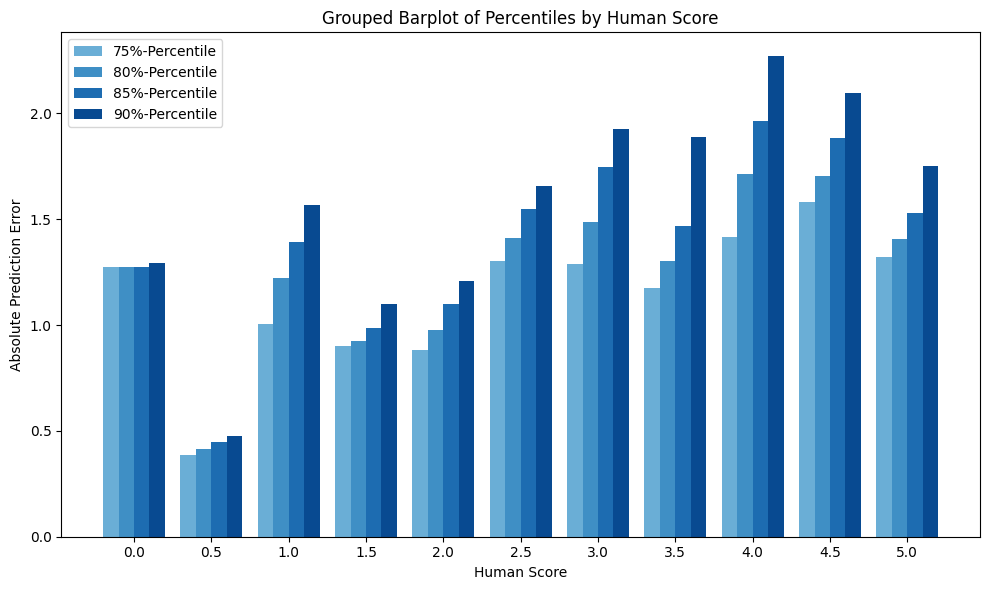

In [31]:
#x-Axis
x = np.arange(len(df_bar_plot['human_score'])) 
width = 0.2

# Farben für die Perzentile
colors = cm.Blues(np.linspace(0.5, 0.9, len(percentile_cols)))

# Figur und Achse erstellen
fig, ax = plt.subplots(figsize=(10, 6))

# Balken für jedes Perzentil hinzufügen
for i, col in enumerate(percentile_cols):
    legend_label = f"{col.split('_')[1]}%-Percentile"  
    ax.bar(
        x + i * width, 
        df_bar_plot[col],
        width,
        label=legend_label,
        color=colors[i]
    )

# Achsen und Titel anpassen
ax.set_xticks(x + width * (len(percentile_cols) - 1) / 2)
ax.set_xticklabels(df_bar_plot['human_score'])
ax.set_xlabel('Human Score')
ax.set_ylabel('Absolute Prediction Error')
ax.set_title('Grouped Barplot of Percentiles by Human Score')
ax.legend(title='')

# Layout und Anzeige
plt.tight_layout()
plt.show()

In [32]:
customized_html_export(
    df_discrepancy.query("absolute_prediction_error > percentile_75").drop(columns=percentile_cols).sort_values(by='percentile_rank_grouped', ascending=False),
    filename = './exports/mohler_high_discrepency.html',
    display_simple_table_here=False
)

In [33]:
a = df_discrepancy.query("model_score < human_score").shape[0]
b = df_discrepancy.query("model_score > human_score").shape[0]
print(f"model_score < human_score: {a} cases.")
print(f"model_score > human_score:  {b} cases.")

model_score < human_score: 1991 cases.
model_score > human_score:  256 cases.


In [34]:
df_error_per_ques.head(20)

,question,prediction_error
25,12.10 How many steps does it take to search a ...,-1.712500
59,6.4 How can an array be addressed in pointer o...,-1.463846
49,4.3 How are arrays passed to functions?,-1.428833
47,4.1 What are the two different ways of specify...,-1.406833
28,12.5 What is the advantage of linked lists ove...,-1.362857
74,8.6 How are infix expressions evaluated by com...,-1.360926
64,7.2 What is the main advantage of linked lists...,-1.342692
8,10.2 What is the height of a tree?,-1.316458
41,3.2 What is the scope of global variables?,-1.262581
69,7.7 What is the main disadvantage of a doubly-...,-1.253846


In [35]:
df_error_per_ques.tail()

,question,prediction_error
75,8.7 What operations would you need to perform ...,-0.390556
67,7.5 What is the difference between a circular ...,-0.365577
35,2.3 What is the difference between a construct...,-0.320833
5,1.6 Where are variables declared in a C plus p...,-0.235862
0,1.1 What is the role of a prototype program in...,-0.175862


<h4 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 18px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 18px;
    margin-bottom: 8px;
">
    OS Dataset
</h4>

OS verfügt über ein quasiintervallskaliertes True-Label. Das bedeutet:

* Regressionsmaße a la $R^2$, RMSE, MAE oder Pearsons $r$ sinnvoll mit gewissen Einschränkungen, da nur quasi-intervallskalierte True-Labels.
* Weighted Cohens Kappa zwischen ordinal transformierter Vorhersage und True-Label sinnig.
* ROC-AUC-Werte in meinen Augen nicht sinnvoll berechenbar.

__Über alle Fragen hinweg__

In [36]:
qs = []

# specify alias
for alias in ['os_en', 'os_de']:
    print(f"\nAlias: {alias}")
    # initialize results dictionairy
    formal_results[alias] = {}
    
    # copy dataset
    df = evaluation_data.datasets[alias].df.copy()
    
    # specify and prepare model and human_scores     
    # multiplication with 2 because Cohen Kappa needs integer values
    # and is not suitable with decimals
    model_scores = df['model_score_rounded'].astype(int)
    human_scores = df['human_score'].astype(int)
    
    # qs to check that bevor using int() model_score consists out of natural numbers
    qs.append({
        'model_score_rounded': np.sort((df['model_score_rounded']).unique()),
        'human_score': np.sort((df['human_score']).unique())
    })

    # Calculate Kappa Scores
    formal_results[alias]['kappa'] = calculate_kappa_scores(
        human_scores, model_scores
    )

print('\n')
for el in qs: print(el)



Alias: os_en
Unweighted Kappa:		 0.02
Quadratic Weighted Kappa:	 0.37
Linear Weighted Kappa:		 0.34

Alias: os_de
Unweighted Kappa:		 0.03
Quadratic Weighted Kappa:	 0.39
Linear Weighted Kappa:		 0.35


{'model_score_rounded': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 33., 35., 36., 37., 38., 39., 40.]), 'human_score': array([ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  6.5,  7. ,  8. ,  9. ,
       10. , 11. , 12. , 13. , 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
       23. , 24. , 25. , 27. , 28. , 30. , 33. , 35. , 38. , 40. ])}
{'model_score_rounded': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 35., 36., 37., 38., 39., 40.]), 'human_score': array([ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  6.5,  7. ,  8. , 

__Für jede Frage separat__

In [37]:
results_df = pd.DataFrame(
    columns=[
        "alias",
        "question_id_2",
        "kappa_unweighted",
        "kappa_linear",
        "kappa_quadratic"
    ]
)

for alias in ["os_en", "os_de"]:
    # Retrieve all unique question_ids for the current alias
    question_ids = np.sort(evaluation_data.datasets[alias].df["question_id_2"].unique())
    
    for cur_id in question_ids:
        # Filter the DataFrame for the current question_id_2
        df_subset = evaluation_data.datasets[alias].df.query(f"question_id_2 == {cur_id}").copy()
        
        # Prepare scores as integer values
        model_scores = df_subset["model_score_rounded"].astype(int)
        human_scores = df_subset["human_score"].astype(int)
        
        # Calculate Kappa metrics
        kappa_result = calculate_kappa_scores(human_scores, model_scores, shut_up=True)
        
        # Append
        results_df.loc[len(results_df)] = {
            "alias": alias,
            "question_id_2": cur_id,
            "kappa_unweighted": kappa_result["unweighted"],
            "kappa_linear": kappa_result["linear"],
            "kappa_quadratic": kappa_result["quadratic"]
        }

In [38]:
results_df.query("alias == 'os_en'").sort_values(by='kappa_quadratic', ascending=False)

,alias,question_id_2,kappa_unweighted,kappa_linear,kappa_quadratic
2,os_en,3,0.020408,0.418290,0.685429
1,os_en,2,0.003605,0.239689,0.438359
3,os_en,4,0.012010,0.219503,0.374500
4,os_en,5,0.002534,0.213917,0.348011
5,os_en,6,0.016314,0.174713,0.204977
0,os_en,1,-0.005269,0.097941,0.195250


In [39]:
results_df.query("alias == 'os_de'").sort_values(by='kappa_quadratic', ascending=False)

,alias,question_id_2,kappa_unweighted,kappa_linear,kappa_quadratic
8,os_de,3,0.046900,0.424706,0.680364
9,os_de,4,0.012526,0.298415,0.487086
7,os_de,2,0.022245,0.250632,0.440291
10,os_de,5,0.005716,0.240198,0.392993
6,os_de,1,0.003482,0.186049,0.347709
11,os_de,6,0.008546,0.171774,0.209913


In [40]:
special_results = pd.concat([
    special_results_os_dataset['os_en'],
    special_results_os_dataset['os_de']
])

special_results['question_id_2'] = special_results['filter'].str[-1].astype(int)

combined_results_for_paper_OS = pd.merge(
    results_df,
    special_results,
    on=['alias', 'question_id_2']
).filter(
    ['Detailed Name', 'question_id_2', 'kappa_quadratic', 'Pearson']
).sort_values(by = ['Detailed Name', 'kappa_quadratic'], ascending = False)

combined_results_for_paper_OS

,Detailed Name,question_id_2,kappa_quadratic,Pearson
8,OS Dataset (german prompts),3,0.680364,0.696432
9,OS Dataset (german prompts),4,0.487086,0.550735
7,OS Dataset (german prompts),2,0.440291,0.459299
10,OS Dataset (german prompts),5,0.392993,0.624948
6,OS Dataset (german prompts),1,0.347709,0.514925
11,OS Dataset (german prompts),6,0.209913,0.218421
2,OS Dataset (english prompts),3,0.685429,0.703370
1,OS Dataset (english prompts),2,0.438359,0.462509
3,OS Dataset (english prompts),4,0.374500,0.424048
4,OS Dataset (english prompts),5,0.348011,0.601089


In [41]:
pd.merge(
    combined_results_for_paper_OS,
    pd.concat([dimtables['os_en'], dimtables['os_de']]).filter(['question_id_2', 'custom_question_id']).drop_duplicates(),
    on = 'question_id_2'
)[6:13].sort_values(by='kappa_quadratic', ascending=False)

,Detailed Name,question_id_2,kappa_quadratic,Pearson,custom_question_id
6,OS Dataset (english prompts),3,0.685429,0.703370,4
7,OS Dataset (english prompts),2,0.438359,0.462509,5
8,OS Dataset (english prompts),4,0.374500,0.424048,3
9,OS Dataset (english prompts),5,0.348011,0.601089,6
10,OS Dataset (english prompts),6,0.204977,0.227063,2
11,OS Dataset (english prompts),1,0.195250,0.225075,1


<h4 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 18px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 18px;
    margin-bottom: 8px;
">
    SemEval
</h4>

SemEval verfügt über ein binäres True-Label. Das bedeutet:
* Regressionsmaße a la $R^2$, RMSE, MAE oder Pearsons $r$ in meinen Augen völliger Quatsch.
* ROC-AUC wunderbar berechenbar.
* Alle auf Basis der Konfusionsmatrix gebildeten Metriken (F1, Acccuracy etc.) bieten sich an. Aber: gewählter Schwellenwert maßgebend.
* Optimierung des Schwellenwerts lässt Maximum aus Accuracy, F1 etc rausholen

In [42]:
# specify alias
alias = 'semeval'

# initialize results dictionairy
formal_results[alias] = {}

# copy dataset
df = evaluation_data.datasets[alias].df.copy()

# build dummies (0/1-coded)
human_scores = df['metadata_original_label'].apply(lambda x: 1 if x == 'correct' else 0)
model_scores = df['model_score_original'].apply(lambda x: 1 if x >= 50 else 0)

# extract original score
model_score_original = df['model_score_original']

__Cohens Kappa__

In [43]:
# calculate Kappa Scores
formal_results[alias]['kappa'] = calculate_kappa_scores(
    human_scores, model_scores
)

Unweighted Kappa:		 0.44
Quadratic Weighted Kappa:	 0.44
Linear Weighted Kappa:		 0.44


__Classfication metrics__ (using threshold in the middle $\rightarrow$ no optimization)

In [44]:
# calculate Accuracy, F1 etc when using exactly the middle as threshold (no optimization of threshold)
formal_results[alias]['classification_metrics'] = evaluate_classification(
    y_true = human_scores,
    y_pred = model_scores
)

Classification Metrics:
accuracy: 0.7184
precision: 0.6438
recall: 0.8120
f1_score: 0.7182
roc_auc: 0.7282
mcc: 0.4563
Confusion Matrix:
[[8506 4696]
 [1965 8489]]


__ROC-AUC and ROC-Curve__

In [45]:
# Calculate ROC-AUC (schwellenwertunabhängig)
formal_results[alias]['ROC_AUC'] = roc_auc_score(
    human_scores,
    model_score_original
)

print(f"ROC-AUC: {formal_results[alias]['ROC_AUC']}")

ROC-AUC: 0.8088816184838683


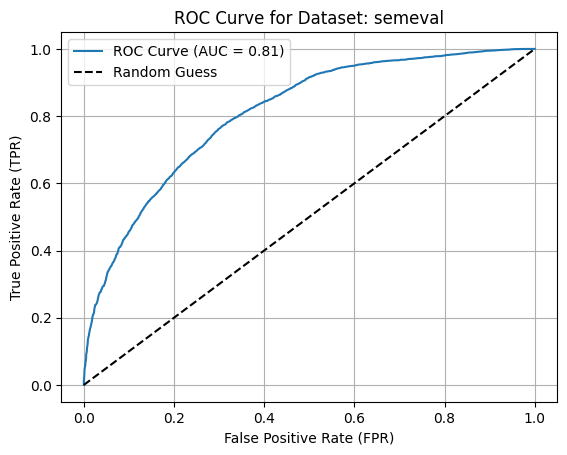

In [46]:
# Plot ROC-Curve
fpr, tpr, thresholds = roc_curve(human_scores, model_score_original)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {formal_results[alias]['ROC_AUC']:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve for Dataset: {alias}')
plt.legend(loc='best')
plt.grid()
filename = 'SemEval_roc_curve'
plt.savefig(f"./exports/{filename}.png")
tikzplotlib.save(f"./exports/{filename}.tex")
plt.show()

__Threshold Optimization__


Optimal threshold analysis:
Optimized for: F1
Best threshold found: 38.600
Maximum f1: 0.719

Performance at best threshold:
Max_f1: 0.719
Accuracy: 0.685
Recall: 0.912
Precision: 0.594
F1: 0.719


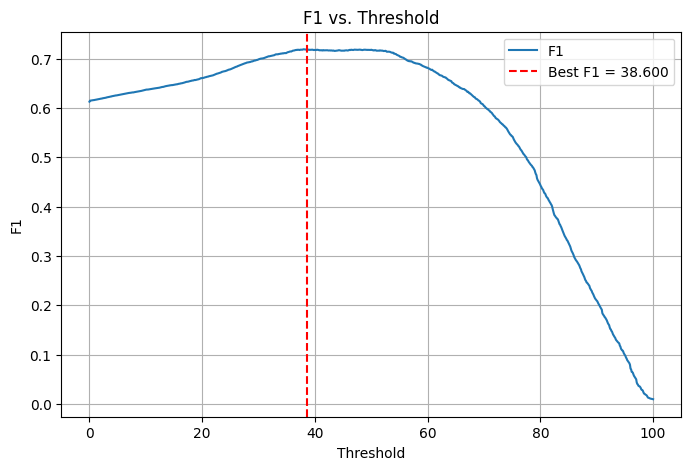

In [47]:
# Optimization
results, f1_values = optimize_threshold(
    y_true_binary = human_scores,
    y_pred_score = model_score_original,
    thresholds = thresholds,
    optimize_for="f1"
)

# 3) Ergebnisse anzeigen
#print("Optimized Metrics:", results)

# Plot results
plot_metric_vs_threshold(
    thresholds,
    f1_values,
    results["best_threshold"],
    metric_name="F1",
    file_path_prefix = './exports/threshold_optimization_F1_semeval'
)


Optimal threshold analysis:
Optimized for: ACCURACY
Best threshold found: 53.900
Maximum accuracy: 0.728

Performance at best threshold:
Max_accuracy: 0.728
Accuracy: 0.728
Recall: 0.761
Precision: 0.669
F1: 0.712


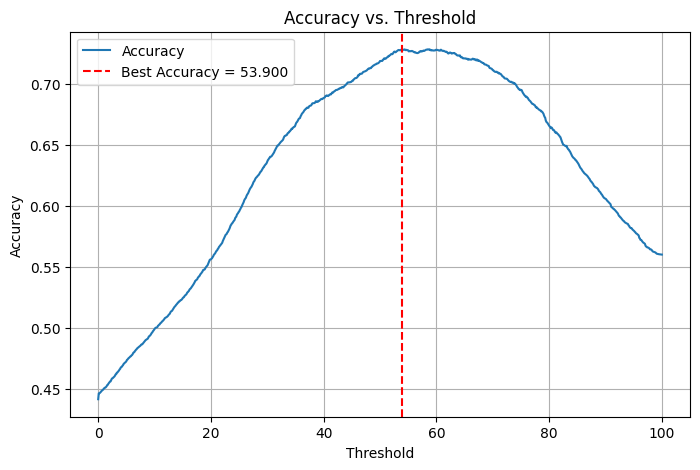

In [48]:
# Optimization
results, acc_values = optimize_threshold(
    y_true_binary = human_scores,
    y_pred_score = model_score_original,
    thresholds = thresholds,
    optimize_for="accuracy"
)

# 3) Ergebnisse anzeigen
#print("Optimized Metrics:", results)

# Plot results
plot_metric_vs_threshold(
    thresholds,
    acc_values,
    results["best_threshold"],
    metric_name="Accuracy",
    file_path_prefix = './exports/threshold_optimization_Acc_semeval'
)


<h4 style="
    font-family: 'Times New Roman', Times, serif;
    font-size: 18px;
    color: #2C3E50;
    text-align: left;
    border-bottom: 1px dotted #BDC3C7;
    padding-bottom: 3px;
    margin-top: 18px;
    margin-bottom: 8px;
">
    SemEval (calculations separately for corpi 'beetle' and 'sciEntsBank')
</h4>

dataset: semeval_beetle
number of Rows: 11978
Unweighted Kappa:		 0.4
Quadratic Weighted Kappa:	 0.4
Linear Weighted Kappa:		 0.4
Classification Metrics:
accuracy: 0.6999
precision: 0.6507
recall: 0.7605
f1_score: 0.7013
roc_auc: 0.7040
mcc: 0.4083
Confusion Matrix:
[[4162 2266]
 [1329 4221]]
ROC-AUC: 0.7748475840495133


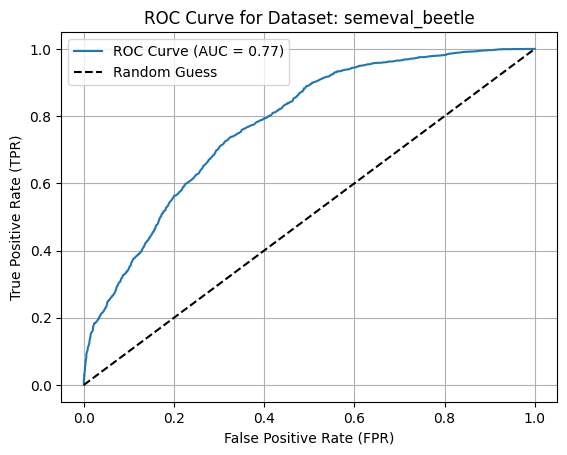


Optimal threshold analysis:
Optimized for: F1
Best threshold found: 37.100
Maximum f1: 0.724

Performance at best threshold:
Max_f1: 0.724
Accuracy: 0.682
Recall: 0.900
Precision: 0.605
F1: 0.724


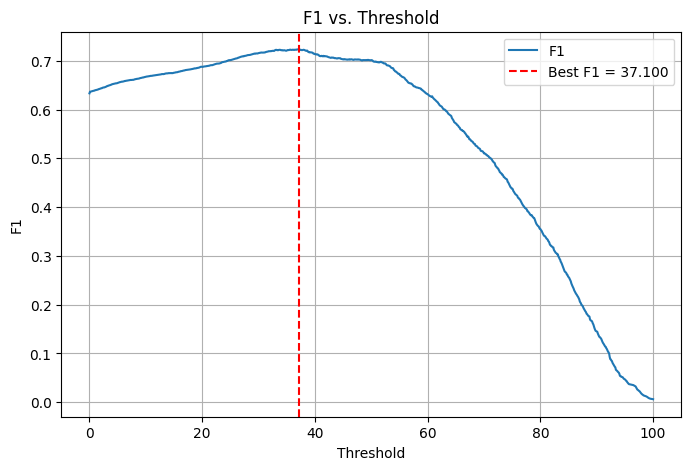


Optimal threshold analysis:
Optimized for: ACCURACY
Best threshold found: 52.500
Maximum accuracy: 0.704

Performance at best threshold:
Max_accuracy: 0.704
Accuracy: 0.704
Recall: 0.725
Precision: 0.667
F1: 0.694


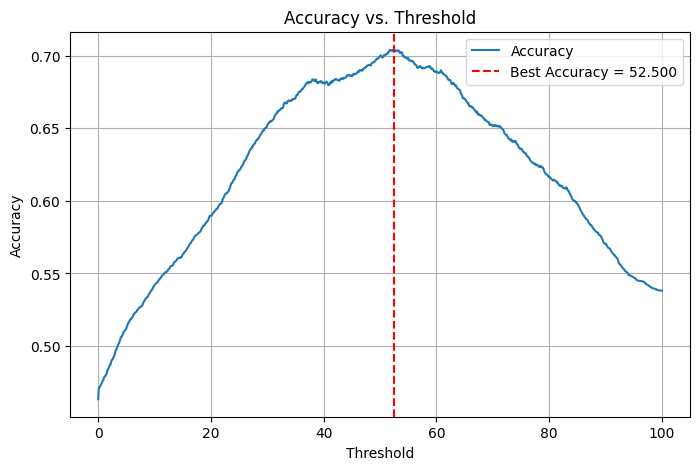

dataset: semeval_sciEntsBank
number of Rows: 11678
Unweighted Kappa:		 0.49
Quadratic Weighted Kappa:	 0.49
Linear Weighted Kappa:		 0.49
Classification Metrics:
accuracy: 0.7375
precision: 0.6372
recall: 0.8703
f1_score: 0.7357
roc_auc: 0.7558
mcc: 0.5105
Confusion Matrix:
[[4344 2430]
 [ 636 4268]]
ROC-AUC: 0.8498880001791707


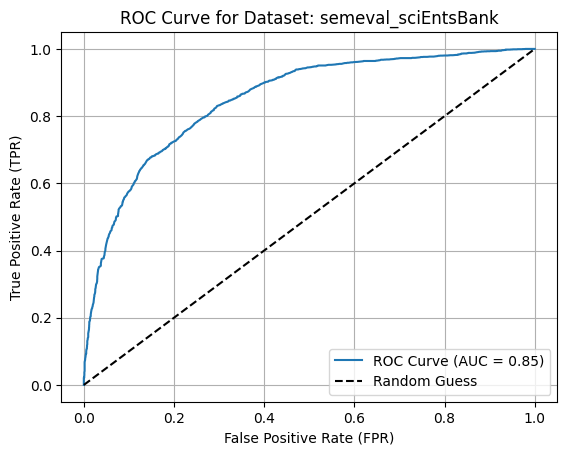


Optimal threshold analysis:
Optimized for: F1
Best threshold found: 54.300
Maximum f1: 0.742

Performance at best threshold:
Max_f1: 0.742
Accuracy: 0.757
Recall: 0.830
Precision: 0.670
F1: 0.742


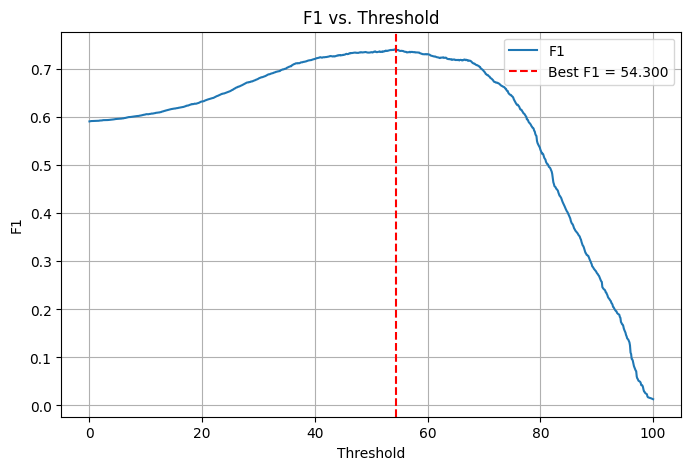


Optimal threshold analysis:
Optimized for: ACCURACY
Best threshold found: 67.500
Maximum accuracy: 0.779

Performance at best threshold:
Max_accuracy: 0.779
Accuracy: 0.779
Recall: 0.669
Precision: 0.775
F1: 0.718


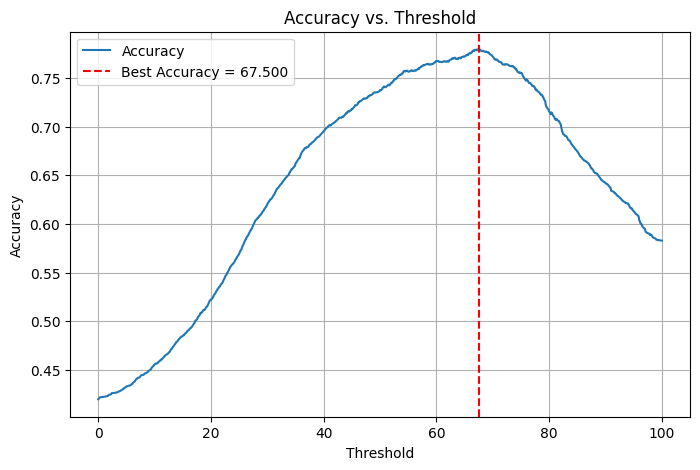

In [49]:
# Corpus
for corpus in ['beetle', 'sciEntsBank']:
   
    # specify alias
    alias = 'semeval'
    
    # fetch dataset
    df = evaluation_data.datasets[alias].df.copy()
    df = df.query(f"metadata_corpus == '{corpus}'")
    n_rows = df.shape[0]
    
    # re-specify alias
    alias = f"{alias}_{corpus}"
    
    print("===========================================================")
    print(f"dataset: {alias}\nnumber of Rows: {n_rows}")
    print("===========================================================")
    
    # initialize results dictionairy
    formal_results[f"{alias}"] = {}
    
    # build dummies (0/1-coded)
    human_scores = df['metadata_original_label'].apply(lambda x: 1 if x == 'correct' else 0)
    model_scores = df['model_score_original'].apply(lambda x: 1 if x >= 50 else 0)
    
    # extract original score
    model_score_original = df['model_score_original']
    
    
    # calculate Kappa Scores
    formal_results[alias]['kappa'] = calculate_kappa_scores(
        human_scores, model_scores
    )
    
    # calculate Accuracy, F1 etc when using exactly the middle as threshold (no optimization of threshold)
    formal_results[alias]['classification_metrics'] = evaluate_classification(
        y_true = human_scores,
        y_pred = model_scores
    )
    
    # Calculate ROC-AUC (schwellenwertunabhängig)
    formal_results[alias]['ROC_AUC'] = roc_auc_score(
        human_scores,
        model_score_original
    )
    
    print(f"ROC-AUC: {formal_results[alias]['ROC_AUC']}")
    
    
    # Plot ROC-Curve
    fpr, tpr, thresholds = roc_curve(human_scores, model_score_original)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {formal_results[alias]['ROC_AUC']:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve for Dataset: {alias}')
    plt.legend(loc='best')
    plt.grid()
    filename = f'semeval_roc_curve_{alias}'
    plt.savefig(f"./exports/{filename}.png")
    tikzplotlib.save(f"./exports/{filename}.tex")
    plt.show()
    
    # Optimization F1
    results, f1_values = optimize_threshold(
        y_true_binary = human_scores,
        y_pred_score = model_score_original,
        thresholds = thresholds,
        optimize_for="f1"
    )
    
    plot_metric_vs_threshold(
        thresholds,
        f1_values,
        results["best_threshold"],
        metric_name="F1",
        file_path_prefix = f'./exports/threshold_optimization_F1_{alias}'
    )
    
    # Optimization Acc
    results, acc_values = optimize_threshold(
        y_true_binary = human_scores,
        y_pred_score = model_score_original,
        thresholds = thresholds,
        optimize_for="accuracy"
    )
    
    plot_metric_vs_threshold(
        thresholds,
        acc_values,
        results["best_threshold"],
        metric_name="Accuracy",
        file_path_prefix = f'./exports/threshold_optimization_Acc_{alias}'
    )
    
    


In [50]:
with open("formal_results.json", "w") as file:
    json.dump(formal_results, file, indent=4) 